In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/IR/archive.zip"

In [4]:
from os import listdir
from pickle import dump
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.models import Model

In [5]:
#extract features from all photos in library
model = VGG19(weights='imagenet')
#remove classification layer
model.layers.pop()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
print(model.summary())


574726144/574710816 [==============================] - 13s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [6]:
def extract_features(filename):
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

In [7]:
import pickle

In [8]:
with open(r"/content/drive/MyDrive/IR/cluster.pkl", "rb") as input_file:
    groups = pickle.load(input_file)

In [9]:

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [10]:
with open(r"/content/drive/MyDrive/IR/kmeans.pkl", "rb") as input_file:
    kmeans = pickle.load(input_file)

In [11]:
with open(r"/content/drive/MyDrive/IR/pca.pkl", "rb") as input_file:
    pca = pickle.load(input_file)

In [12]:
with open(r"/content/drive/MyDrive/IR/features.pkl", "rb") as input_file:
    features = pickle.load(input_file)

In [13]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel


In [14]:
def search_images(img, n=10):
    feat = extract_features(img)
    dimn = pca.transform(feat)
    pred = kmeans.predict(dimn)
    nfet = np.asarray(feat, dtype=np.float32)
    lis = []
    # print(groups[pred[0]])
    for img in groups[pred[0]]:
        t = (rbf_kernel(nfet, features[img]), img)
        lis.append(t)
    lis.sort(reverse=True)
    return lis[:min(n, len(lis))]

In [15]:
def search_images_entire(img, n=10):
    feat = extract_features(img)
    dimn = pca.transform(feat)
    pred = kmeans.predict(dimn)
    nfet = np.asarray(feat, dtype=np.float32)
    lis = []
    # print(groups[pred[0]])
    for i in range(50):
      for img in groups[i]:
          t = (rbf_kernel(nfet, features[img]), img)
          lis.append(t)
    lis.sort(reverse=True)
    return lis[:min(n, len(lis))]

In [24]:
test_path = "/content/322868_1100-800x825.jpg"

In [25]:
imgs = search_images(test_path, 15)
# imgs_entire = search_images_entire(test_path, 10)

In [26]:
imgs

[(array([[0.16472377]], dtype=float32), '2924870944_90ff9eca1a.jpg'),
 (array([[0.14298758]], dtype=float32), '2079152458_40712c3b40.jpg'),
 (array([[0.1283445]], dtype=float32), '1522787272_5a31497ef2.jpg'),
 (array([[0.12439496]], dtype=float32), '373219198_149af371d9.jpg'),
 (array([[0.11244971]], dtype=float32), '3106883334_419f3fb16f.jpg'),
 (array([[0.11167248]], dtype=float32), '494792770_2c5f767ac0.jpg'),
 (array([[0.10869467]], dtype=float32), '240583223_e26e17ee96.jpg'),
 (array([[0.10806063]], dtype=float32), '3446586125_cafa0bfd67.jpg'),
 (array([[0.10221312]], dtype=float32), '3463922449_f6040a2931.jpg'),
 (array([[0.09596016]], dtype=float32), '2219805467_370ee1b7aa.jpg'),
 (array([[0.09562771]], dtype=float32), '587604325_af5d6df679.jpg'),
 (array([[0.08554108]], dtype=float32), '2938120171_970564e3d8.jpg'),
 (array([[0.08512748]], dtype=float32), '2587017287_888c811b5a.jpg'),
 (array([[0.08391356]], dtype=float32), '3726168984_1fa2c8965b.jpg'),
 (array([[0.08346218]], d

In [27]:
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

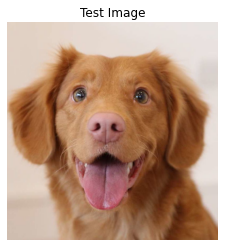

In [28]:
test = PIL.Image.open(test_path)
plt.title("Test Image")
plt.axis('off')
plt.imshow(test)

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    n_images = len(images)
    # if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (score,image) in enumerate(images):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        test = PIL.Image.open("/content/Images/"+image)
        plt.imshow(test)
        a.set_title(f"similarity score : {score[0][0]}")
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

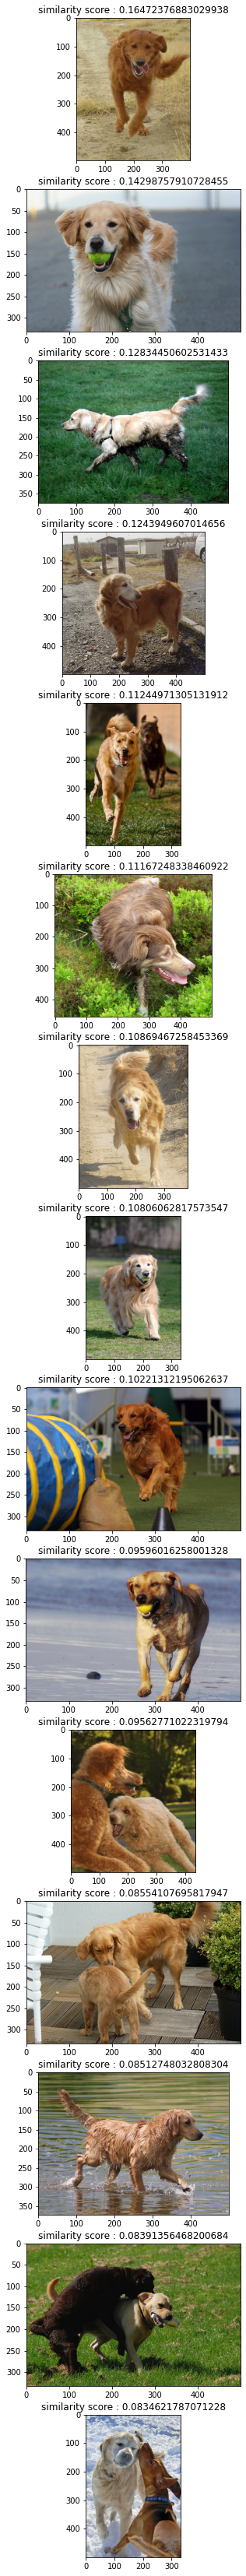

In [30]:
show_images(imgs, len(imgs))